# 第10章 日本語Tacotronに基づく音声合成システムの実装

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/r9y9/ttslearn/blob/master/notebooks/ch10_Recipe-Tacotron.ipynb)

Google colabでの実行における推定所要時間: 5時間

このノートブックに記載のレシピの設定は、Google Colab上で実行した場合のタイムアウトを避けるため、学習条件を書籍に記載の設定から一部修正していることに注意してください (バッチサイズを減らす等)。
参考までに、書籍に記載の条件で、著者 (山本) がレシピを実行した結果を以下で公開しています。

- Tensorboard logs: https://tensorboard.dev/experiment/gHKogn7wRxa4B3NIVw27xw/
- expディレクトリ(学習済みモデル、合成音声を含む) : https://drive.google.com/file/d/1LoIGkwTLUZmkJkxbTR1S7yyaWexn-Wfp/view?usp=sharing (226.9 MB)

## 準備

### Google Colabを利用する場合

Google Colab上でこのノートブックを実行する場合は、メニューの「ランタイム -> ランタイムのタイムの変更」から、「ハードウェア アクセラレータ」を **GPU** に変更してください。

### Python version

In [1]:
!python -VV

Python 3.7.11 (default, Jul 27 2021, 14:32:16) 
[GCC 7.5.0]


### ttslearn のインストール

In [2]:
%%capture
try:
    import ttslearn
except ImportError:
    !pip install ttslearn

In [3]:
import ttslearn
ttslearn.__version__

'0.2.2'

## 10.1 本章の日本語音声合成システムの実装

### 学習済みモデルを用いた音声合成

In [4]:
from ttslearn.tacotron import Tacotron2TTS
from tqdm.notebook import tqdm
from IPython.display import Audio

engine = Tacotron2TTS()
wav, sr = engine.tts("一貫学習にチャレンジしましょう！", tqdm=tqdm)
Audio(wav, rate=sr)

  0%|          | 0/32000 [00:00<?, ?it/s]

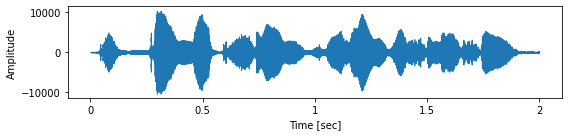

In [5]:
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8,2))
librosa.display.waveshow(wav.astype(np.float32), sr=sr, ax=ax)
ax.set_xlabel("Time [sec]")
ax.set_ylabel("Amplitude")
plt.tight_layout()

### レシピ実行の前準備

In [6]:
%%capture
from ttslearn.env import is_colab
from os.path import exists

# pip install ttslearn ではレシピはインストールされないので、手動でダウンロード
if is_colab() and not exists("recipes.zip"):
    !curl -LO https://github.com/r9y9/ttslearn/releases/download/v{ttslearn.__version__}/recipes.zip
    !unzip -o recipes.zip

In [7]:
import os
# recipeのディレクトリに移動
cwd = os.getcwd()
if cwd.endswith("notebooks"):
    os.chdir("../recipes/tacotron/")
elif is_colab():
    os.chdir("recipes/tacotron/")   

In [8]:
import time
start_time = time.time()

### パッケージのインポート

In [9]:
%pylab inline
%load_ext autoreload
%load_ext tensorboard
%autoreload
import IPython
from IPython.display import Audio
import tensorboard as tb
import os

Populating the interactive namespace from numpy and matplotlib


In [10]:
# 数値演算
import numpy as np
import torch
from torch import nn
# 音声波形の読み込み
from scipy.io import wavfile
# フルコンテキストラベル、質問ファイルの読み込み
from nnmnkwii.io import hts
# 音声分析
import pyworld
# 音声分析、可視化
import librosa
import librosa.display
import pandas as pd
# Pythonで学ぶ音声合成
import ttslearn

In [11]:
# シードの固定
from ttslearn.util import init_seed
init_seed(773)

In [12]:
torch.__version__

'1.10.0'

### 描画周りの設定

In [13]:
from ttslearn.notebook import get_cmap, init_plot_style, savefig
cmap = get_cmap()
init_plot_style()

### レシピの設定

In [14]:
# run.shを利用した学習スクリプトをnotebookから行いたい場合は、True
# google colab の場合は、True とします
# ローカル環境の場合、run.sh をターミナルから実行することを推奨します。
# その場合、このノートブックは可視化・学習済みモデルのテストのために利用します。
run_sh = is_colab()

# 注意: WaveNetを利用した評価データに対する音声生成は時間がかかることに注意
run_stage6 = True

# run.sh経由で実行するスクリプトのtqdm
run_sh_tqdm = "none"

# CUDA
# NOTE: run.shの引数として渡すので、boolではなく文字列で定義しています
cudnn_benchmark = "true"
cudnn_deterministic = "false"

# 特徴抽出時の並列処理のジョブ数
n_jobs = os.cpu_count()//2

# 音響モデル (Tacotron) の設定ファイル名
acoustic_config_name="tacotron2_rf2"
# WaveNetボコーダの設定ファイル名
wavenet_config_name="wavenet_sr16k_mulaw256_30layers"

# Tacotron学習におけるバッチサイズ
tacotron_batch_size = 16
# Tacotron学習のイテレーション数
# 注意: 十分な品質を得るために必要な値: 50k ~ 100k steps
tacotron_max_train_steps = 5000

# WaveNetボコーダの学習におけるバッチサイズ
# 推奨バッチサイズ:  8以上
# 動作確認のため、小さな値に設定しています
wavenet_batch_size = 4
# WavaNetの学習イテレーション数
# 注意: 十分な品質を得るために必要な値: 300k ~ 500k steps
wavenet_max_train_steps = 20000

# 音声生成を行う発話数
# WaveNetの推論は時間がかかるので、ノートブックで表示する5つのみ生成する
num_eval_utts = 5

# ノートブックで利用するテスト用の発話（学習データ、評価データ）
train_utt = "BASIC5000_0001"
test_utt = "BASIC5000_5000"

### Tensorboard によるログの可視化

In [15]:
# ノートブック上から tensorboard のログを確認する場合、次の行を有効にしてください
if is_colab():
    %tensorboard --logdir tensorboard/

## 10.2 Tacotron 2 を日本語に適用するための変更

### 音素列と韻律記号付き音素列の比較

In [16]:
import pyopenjtalk
# この実装は後述します
from ttslearn.tacotron.frontend.openjtalk import pp_symbols

In [17]:
print("音素列:", pyopenjtalk.g2p("端が"))
print("音素列:", pyopenjtalk.g2p("箸が"))
print("音素列:", pyopenjtalk.g2p("橋が"))

音素列: h a sh i g a
音素列: h a sh i g a
音素列: h a sh i g a


In [18]:
print("韻律記号付き音素列:", " ".join(pp_symbols(pyopenjtalk.extract_fullcontext("端が"))))
print("韻律記号付き音素列:", " ".join(pp_symbols(pyopenjtalk.extract_fullcontext("箸が"))))
print("韻律記号付き音素列:", " ".join(pp_symbols(pyopenjtalk.extract_fullcontext("橋が"))))

韻律記号付き音素列: ^ h a [ sh i g a $
韻律記号付き音素列: ^ h a ] sh i g a $
韻律記号付き音素列: ^ h a [ sh i ] g a $


### フルコンテキストラベルからの音素列および韻律記号の抽出

In [19]:
import re

def numeric_feature_by_regex(regex, s):
    match = re.search(regex, s)
    # 未定義 (xx) の場合、コンテキストの取りうる値以外の適当な値
    if match is None:
        return -50
    return int(match.group(1))

In [20]:
labels = hts.load(ttslearn.util.example_label_file())
labels.contexts[1]

'xx^sil-m+i=z/A:-2+1+3/B:xx-xx_xx/C:02_xx+xx/D:13+xx_xx/E:xx_xx!xx_xx-xx/F:3_3#0_xx@1_5|1_23/G:7_2%0_xx_1/H:xx_xx/I:5-23@1+1&1-5|1+23/J:xx_xx/K:1+5-23'

In [21]:
numeric_feature_by_regex(r"/A:([0-9\-]+)\+", labels.contexts[1])

-2

In [22]:
def pp_symbols(labels, drop_unvoiced_vowels=True):
    PP = []
    N = len(labels)

    # 各音素毎に順番に処理
    for n in range(N):
        lab_curr = labels[n]

        # 当該音素
        p3 = re.search(r"\-(.*?)\+", lab_curr).group(1)

        # 無声化母音を通常の母音として扱う
        if drop_unvoiced_vowels and p3 in "AEIOU":
            p3 = p3.lower()

        # 先頭と末尾の sil のみ例外対応
        if p3 == "sil":
            assert n == 0 or n == N - 1
            if n == 0:
                PP.append("^")
            elif n == N - 1:
                # 疑問系かどうか
                e3 = numeric_feature_by_regex(r"!(\d+)_", lab_curr)
                if e3 == 0:
                    PP.append("$")
                elif e3 == 1:
                    PP.append("?")
            continue
        elif p3 == "pau":
            PP.append("_")
            continue
        else:
            PP.append(p3)

        # アクセント型および位置情報（前方または後方）
        a1 = numeric_feature_by_regex(r"/A:([0-9\-]+)\+", lab_curr)
        a2 = numeric_feature_by_regex(r"\+(\d+)\+", lab_curr)
        a3 = numeric_feature_by_regex(r"\+(\d+)/", lab_curr)
        # アクセント句におけるモーラ数
        f1 = numeric_feature_by_regex(r"/F:(\d+)_", lab_curr)

        a2_next = numeric_feature_by_regex(r"\+(\d+)\+", labels[n + 1])

        # アクセント句境界
        if a3 == 1 and a2_next == 1:
            PP.append("#")
        # ピッチの立ち下がり（アクセント核）
        elif a1 == 0 and a2_next == a2 + 1 and a2 != f1:
            PP.append("]")
        # ピッチの立ち上がり
        elif a2 == 1 and a2_next == 2:
            PP.append("[")

    return PP

In [23]:
import pyopenjtalk

text = "今日の天気は？"

# テキストからフルコンテキストを抽出
labels = pyopenjtalk.extract_fullcontext(text)
# フルコンテキストから、韻律記号付き音素列に変換
PP = pp_symbols(labels)

print("入力文字列:", text)
print("音素列:", pyopenjtalk.g2p(text))
print("韻律記号付き音素列:", " ".join(PP))

入力文字列: 今日の天気は？
音素列: ky o o n o t e N k i w a
韻律記号付き音素列: ^ ky o ] o n o # t e ] N k i w a ?


## プログラム実装の前準備

### stage -1: コーパスのダウンロード

In [24]:
if is_colab():
    ! ./run.sh --stage -1 --stop-stage -1

### Stage 0: 学習/検証/評価データの分割

In [25]:
if run_sh:
    ! ./run.sh --stage 0 --stop-stage 0

In [26]:
! ls data/

dev.list  eval.list  train.list  utt_list.txt


In [27]:
! head data/dev.list

BASIC5000_4701
BASIC5000_4702
BASIC5000_4703
BASIC5000_4704
BASIC5000_4705
BASIC5000_4706
BASIC5000_4707
BASIC5000_4708
BASIC5000_4709
BASIC5000_4710


## 10.3 データの前処理

### Tacotron 2 のための前処理

#### 1発話に対する前処理

In [28]:
from ttslearn.tacotron.frontend.openjtalk import text_to_sequence, pp_symbols
from ttslearn.dsp import mulaw_quantize, logmelspectrogram

# 韻律記号付き音素列の抽出
labels = hts.load(ttslearn.util.example_label_file())
PP = pp_symbols(labels.contexts)
in_feats = np.array(text_to_sequence(PP), dtype=np.int64)

# メルスペクトログラムの計算
sr = 16000
_sr, x = wavfile.read(ttslearn.util.example_audio_file())
x = (x / 32768).astype(np.float64)
x = librosa.resample(x,orig_sr= _sr,target_sr= sr)

hop_length = int(0.0125 * sr)
# sp = logmelspectrogram(x, sr, hop_length=hop_length)
win_length = int(sr * 0.05)  # 50ms
n_fft = ttslearn.dsp.next_power_of_2(win_length)
s = librosa.stft(
    x,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    window="hanning",
)

fmin = 0
fmax = sr // 2
mel_basis = librosa.filters.mel(sr=sr, n_fft=n_fft, fmin=fmin, fmax=fmax, n_mels=80)
# メルフィルタバンクの適用
s = np.dot(mel_basis, np.abs(s))
s = np.maximum(s,0.001)
s = np.log10(s)
out_feats = s.T
# out_feats = logmelspectrogram(x, sr)

# 冒頭と末尾の非音声区間の長さを調整
assert "sil" in labels.contexts[0] and "sil" in labels.contexts[-1]
start_frame = int(labels.start_times[1] / 125000)
end_frame = int(labels.end_times[-2] / 125000)

# 最初：50 ミリ秒、最後：100 ミリ秒
start_frame = max(0, start_frame - int(0.050 / 0.0125))
end_frame = min(len(out_feats), end_frame + int(0.100 / 0.0125))

out_feats = out_feats[start_frame:end_frame]

# 時間領域で音声の長さを調整
x = x[int(start_frame * 0.0125 * sr) :]
length = int(sr * 0.0125) * out_feats.shape[0]
x = pad_1d(x, length) if len(x) < length else x[:length]

# 特徴量のアップサンプリングを行う都合上、音声波形の長さはフレームシフトで割り切れる必要があります
assert len(x) % int(sr * 0.0125) == 0

# mu-law 量子化
x = mulaw_quantize(x)

In [29]:
print("Tacotron の入力特徴量のサイズ:", in_feats.shape)
print("Tacotron の出力特徴量のサイズ:", out_feats.shape)
print("WaveNet ボコーダの出力の音声波形のサイズ:", x.shape)

Tacotron の入力特徴量のサイズ: (56,)
Tacotron の出力特徴量のサイズ: (227, 80)
WaveNet ボコーダの出力の音声波形のサイズ: (45400,)


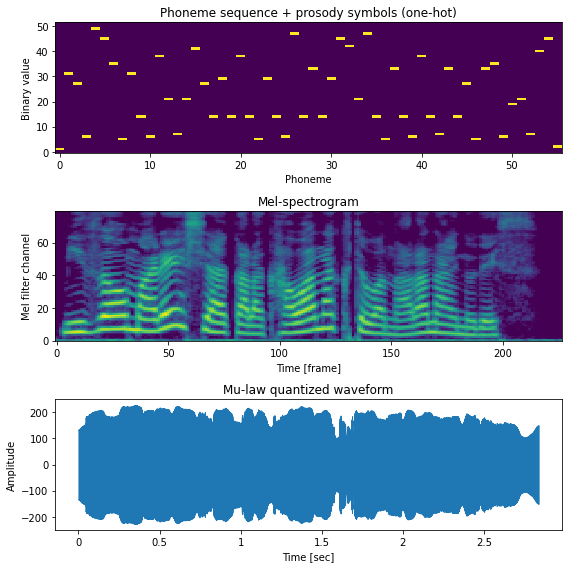

In [30]:
from ttslearn.tacotron.frontend.openjtalk import num_vocab
from ttslearn.dsp import inv_mulaw_quantize
from torch.nn import functional as F

inp = F.one_hot(torch.from_numpy(in_feats), num_vocab()).numpy()

fig, ax = plt.subplots(3, 1, figsize=(8,8))
ax[0].set_title("Phoneme sequence + prosody symbols (one-hot)")
ax[1].set_title("Mel-spectrogram")
ax[2].set_title("Mu-law quantized waveform")

ax[0].imshow(inp.T, aspect="auto", interpolation="nearest", origin="lower", cmap=cmap)
ax[1].imshow(out_feats.T, aspect="auto", interpolation="nearest", origin="lower", cmap=cmap)
librosa.display.waveshow(x.astype(np.float32), ax=ax[2], sr=sr)

ax[0].set_xlabel("Phoneme")
ax[0].set_ylabel("Binary value")
ax[1].set_xlabel("Time [frame]")
ax[1].set_ylabel("Mel filter channel")
ax[2].set_xlabel("Time [sec]")
ax[2].set_ylabel("Amplitude")

plt.tight_layout()
savefig("fig/e2etts_impl_taco2_inout")

#### レシピの stage 1 の実行

バッチ処理を行うコマンドラインプログラムは、 `preprocess.py` を参照してください。

In [31]:
if run_sh:
    ! ./run.sh --stage 1 --stop-stage 1

### 特徴量の正規化

正規化のための統計量を計算するコマンドラインプログラムは、 `recipes/common/fit_scaler.py` を参照してください。また、正規化を行うコマンドラインプログラムは、 `recipes/common/preprocess_normalize.py` を参照してください。

#### レシピの stage 2 の実行

In [32]:
if run_sh:
    ! ./run.sh --stage 2 --stop-stage 2 --n-jobs $n_jobs

#### 正規化の処理の結果の確認

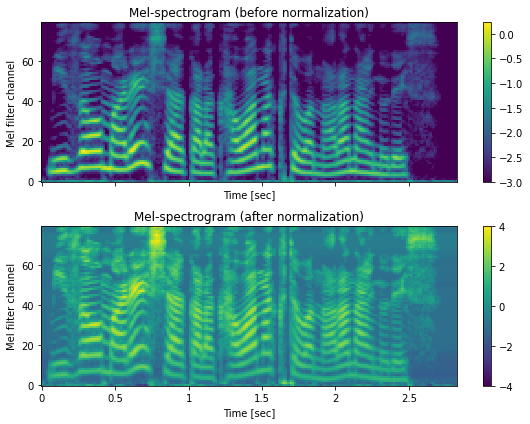

In [33]:
in_feats = np.load(f"dump/jsut_sr16000/org/train/out_tacotron/{train_utt}-feats.npy")
in_feats_norm = np.load(f"dump/jsut_sr16000/norm/train/out_tacotron/{train_utt}-feats.npy")
fig, ax = plt.subplots(2, 1, figsize=(8,6), sharex=True)
ax[0].set_title("Mel-spectrogram (before normalization)")
ax[1].set_title("Mel-spectrogram (after normalization)")

hop_length = int(sr * 0.0125)
mesh = librosa.display.specshow(
    in_feats.T, sr=sr, hop_length=hop_length, x_axis="time", y_axis="frames", ax=ax[0], cmap=cmap)
fig.colorbar(mesh, ax=ax[0])
mesh = librosa.display.specshow(
    in_feats_norm.T, sr=sr, hop_length=hop_length, x_axis="time", y_axis="frames",ax=ax[1], cmap=cmap)
mesh.set_clim(-4, 4)
fig.colorbar(mesh, ax=ax[1])

for a in ax:
    a.set_xlabel("Time [sec]")
    a.set_ylabel("Mel filter channel")
plt.tight_layout()

## 10.4 Tacotron の学習スクリプトの作成

### DataLoader の実装

#### collate_fn の実装

In [34]:
def ensure_divisible_by(feats, N):
    if N == 1:
        return feats
    mod = len(feats) % N
    if mod != 0:
        feats = feats[: len(feats) - mod]
    return feats

In [35]:
from ttslearn.util import pad_1d, pad_2d

def collate_fn_tacotron(batch, reduction_factor=1):
    xs = [x[0] for x in batch]
    ys = [ensure_divisible_by(x[1], reduction_factor) for x in batch]
    in_lens = [len(x) for x in xs]
    out_lens = [len(y) for y in ys]
    in_max_len = max(in_lens)
    out_max_len = max(out_lens)
    x_batch = torch.stack([torch.from_numpy(pad_1d(x, in_max_len)) for x in xs])
    y_batch = torch.stack([torch.from_numpy(pad_2d(y, out_max_len)) for y in ys])
    in_lens = torch.tensor(in_lens, dtype=torch.long)
    out_lens = torch.tensor(out_lens, dtype=torch.long)
    stop_flags = torch.zeros(y_batch.shape[0], y_batch.shape[1])
    for idx, out_len in enumerate(out_lens):
        stop_flags[idx, out_len - 1 :] = 1.0
    return x_batch, in_lens, y_batch, out_lens, stop_flags

#### DataLoader の利用例

In [36]:
from pathlib import Path
from ttslearn.train_util import Dataset, collate_fn_tacotron
from functools import partial

in_paths = sorted(Path("./dump/jsut_sr16000/norm/dev/in_tacotron/").glob("*.npy"))
out_paths = sorted(Path("./dump/jsut_sr16000/norm/dev/out_tacotron/").glob("*.npy"))

dataset = Dataset(in_paths, out_paths)
collate_fn = partial(collate_fn_tacotron, reduction_factor=1)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=8, collate_fn=collate_fn, num_workers=0)

in_feats, in_lens, out_feats, out_lens, stop_flags = next(iter(data_loader))
print("入力特徴量のサイズ:", tuple(in_feats.shape))
print("出力特徴量のサイズ:", tuple(out_feats.shape))
print("stop flags のサイズ:", tuple(stop_flags.shape))

入力特徴量のサイズ: (8, 66)
出力特徴量のサイズ: (8, 286, 80)
stop flags のサイズ: (8, 286)


#### ミニバッチの可視化

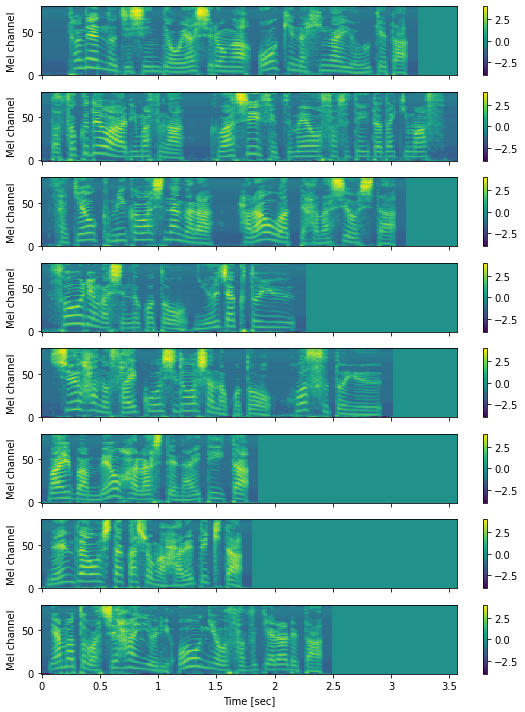

In [37]:
fig, ax = plt.subplots(len(out_feats), 1, figsize=(8,10), sharex=True, sharey=True)
for n in range(len(in_feats)):
    x = out_feats[n].data.numpy()
    hop_length = int(sr * 0.0125)
    mesh = librosa.display.specshow(x.T, sr=sr, x_axis="time", y_axis="frames", hop_length=hop_length, cmap=cmap, ax=ax[n])
    fig.colorbar(mesh, ax=ax[n])
    mesh.set_clim(-4, 4)
    # あとで付け直すので、ここではラベルを削除します
    ax[n].set_xlabel("")
    
ax[-1].set_xlabel("Time [sec]")
for a in ax:
    a.set_ylabel("Mel channel")

plt.tight_layout()
savefig("fig/e2etts_impl_minibatch")

### 簡易的な学習スクリプトの実装

#### 学習の前準備

In [38]:
from ttslearn.tacotron import Tacotron2 as Tacotron
from torch import optim

# 動作確認用：層の数を減らした小さなTacotron
model = Tacotron(
    embed_dim=32, encoder_conv_layers=1, encoder_conv_channels=32, encoder_hidden_dim=32,
    decoder_hidden_dim=32, postnet_channels=32, postnet_layers=1)

# lr は学習率を表します
optimizer = optim.Adam(model.parameters(), lr=0.001)

# gamma は学習率の減衰係数を表します
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, gamma=0.5, step_size=100000)

#### 学習ループの実装

In [39]:
from ttslearn.util import make_non_pad_mask

# DataLoader を用いたミニバッチの作成: ミニバッチ毎に処理する
for in_feats, in_lens, out_feats, out_lens, stop_flags in tqdm(data_loader):
    in_lens, indices = torch.sort(in_lens, dim=0, descending=True)
    in_feats, out_feats, out_lens = in_feats[indices], out_feats[indices], out_lens[indices]
    
    # 順伝搬の計算
    outs, outs_fine, logits, _ = model(in_feats, in_lens, out_feats)
    
    # ゼロパディグした部分を損失関数のの計算から除外するためにマスクを適用します
    # Mask (B x T x 1)
    mask = make_non_pad_mask(out_lens).unsqueeze(-1)
    out_feats = out_feats.masked_select(mask)
    outs = outs.masked_select(mask)
    outs_fine = outs_fine.masked_select(mask)
    stop_flags = stop_flags.masked_select(mask.squeeze(-1))
    logits = logits.masked_select(mask.squeeze(-1))

    # 損失の計算
    decoder_out_loss = nn.MSELoss()(outs, out_feats)
    postnet_out_loss = nn.MSELoss()(outs_fine, out_feats) 
    stop_token_loss = nn.BCEWithLogitsLoss()(logits, stop_flags)
    
    # 損失の合計
    loss = decoder_out_loss + postnet_out_loss + stop_token_loss

    # 損失の値を出力
    print(f"decoder_out_loss: {decoder_out_loss:.2f}, postnet_out_loss: {postnet_out_loss:.2f}, stop_token_loss: {stop_token_loss:.2f}")
    # optimizer に蓄積された勾配をリセット
    optimizer.zero_grad()
    # 誤差の逆伝播
    loss.backward()
    # パラメータの更新
    optimizer.step()
    # 学習率スケジューラの更新
    lr_scheduler.step()

  0%|          | 0/25 [00:00<?, ?it/s]

decoder_out_loss: 1.06, postnet_out_loss: 3.13, stop_token_loss: 0.75
decoder_out_loss: 1.01, postnet_out_loss: 3.07, stop_token_loss: 0.72
decoder_out_loss: 1.00, postnet_out_loss: 3.03, stop_token_loss: 0.73
decoder_out_loss: 0.98, postnet_out_loss: 3.17, stop_token_loss: 0.72
decoder_out_loss: 0.98, postnet_out_loss: 2.98, stop_token_loss: 0.70
decoder_out_loss: 0.95, postnet_out_loss: 2.88, stop_token_loss: 0.70
decoder_out_loss: 0.96, postnet_out_loss: 2.96, stop_token_loss: 0.69
decoder_out_loss: 0.99, postnet_out_loss: 2.81, stop_token_loss: 0.68
decoder_out_loss: 0.98, postnet_out_loss: 2.84, stop_token_loss: 0.68
decoder_out_loss: 0.97, postnet_out_loss: 2.84, stop_token_loss: 0.66
decoder_out_loss: 1.00, postnet_out_loss: 2.83, stop_token_loss: 0.66
decoder_out_loss: 1.02, postnet_out_loss: 2.88, stop_token_loss: 0.65
decoder_out_loss: 1.07, postnet_out_loss: 2.67, stop_token_loss: 0.64
decoder_out_loss: 1.04, postnet_out_loss: 2.61, stop_token_loss: 0.62
decoder_out_loss: 1.

### アテンション重みの可視化

ここでは、学習が正常に進行していない場合の例として、意図的に学習済みモデルの一部のパラメータを乱数で初期化します。詳細は、`randomize_tts_engine_` 参照してください。

In [40]:
from ttslearn.tacotron import Tacotron2TTS
from ttslearn.tacotron.tts import randomize_tts_engine_

tacotron_engine = Tacotron2TTS()

tacotron_engine_bad = Tacotron2TTS()
randomize_tts_engine_(tacotron_engine_bad)
print("randomized some of network weights")

randomized some of network weights


In [41]:
text = "世界で一番きれいなお姫様。"

import pyopenjtalk
from ttslearn.tacotron.frontend.openjtalk import text_to_sequence, pp_symbols

labels = pyopenjtalk.extract_fullcontext(text)
# 韻律記号付き音素列
in_feats = text_to_sequence(pp_symbols(labels))
in_feats = torch.tensor(in_feats, dtype=torch.long)

with torch.no_grad():
    outs, outs_fine, logits, att_ws = tacotron_engine.acoustic_model.inference(in_feats)
    
with torch.no_grad():
    outs2, outs_fine2, logits2, att_ws2 = tacotron_engine_bad.acoustic_model.inference(in_feats)

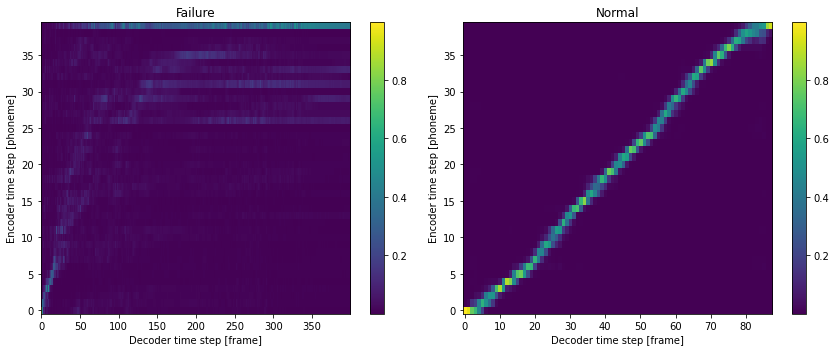

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].set_title("Failure")
ax[1].set_title("Normal")

mesh = ax[0].imshow(att_ws2.cpu().data.numpy().T, aspect="auto", origin="lower", interpolation="nearest")
fig.colorbar(mesh, ax=ax[0])
ax[0].set_xlabel("Decoder time step [frame]")
ax[0].set_ylabel("Encoder time step [phoneme]")

mesh = ax[1].imshow(att_ws.cpu().data.numpy().T, aspect="auto", origin="lower", interpolation="nearest")
fig.colorbar(mesh, ax=ax[1])
ax[1].set_xlabel("Decoder time step [frame]")
ax[1].set_ylabel("Encoder time step [phoneme]")

plt.tight_layout()

# 図10-5
savefig("./fig/e2etts_impl_attention_failure")

### 実用的な学習スクリプトの実装

`train_tacotron.py` を参照してください。

## 10.5 Tacotron の学習

### Tacotron の設定ファイル

In [43]:
! cat conf/train_tacotron/model/{acoustic_config_name}.yaml

netG:
  _target_: ttslearn.tacotron.Tacotron2
  num_vocab: 52
  reduction_factor: 2
  embed_dim: 512
  encoder_hidden_dim: 512
  decoder_out_dim: 80
  encoder_conv_layers: 3
  encoder_conv_channels: 512
  encoder_conv_kernel_size: 5
  encoder_dropout: 0.5
  attention_hidden_dim: 128
  attention_conv_channels: 32
  attention_conv_kernel_size: 31
  decoder_layers: 2
  decoder_hidden_dim: 1024
  decoder_prenet_layers: 2
  decoder_prenet_hidden_dim: 256
  decoder_prenet_dropout: 0.5
  postnet_layers: 5
  postnet_channels: 512
  postnet_kernel_size: 5
  postnet_dropout: 0.5
  decoder_zoneout: 0.1

### Tacotron のインスタンス化

In [44]:
import hydra
from omegaconf import OmegaConf
hydra.utils.instantiate(OmegaConf.load(f"./conf/train_tacotron/model/{acoustic_config_name}.yaml")["netG"])

Tacotron2(
  (encoder): Encoder(
    (embed): Embedding(52, 512, padding_idx=0)
    (convs): Sequential(
      (0): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.5, inplace=False)
      (4): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.5, inplace=False)
      (8): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
      (11): Dropout(p=0.5, inplace=False)
    )
    (blstm): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (attention): LocationSensitiveAttention(
      (mlp_enc): Linear(in_features=512, o

### レシピの stage 3 の実行

In [45]:
if run_sh:
    ! ./run.sh --stage 3 --stop-stage 3 --acoustic-model $acoustic_config_name \
        --tqdm $run_sh_tqdm --tacotron-train-max-train-steps $tacotron_max_train_steps \
        --tacotron-data-batch-size $tacotron_batch_size \
        --cudnn-benchmark $cudnn_benchmark --cudnn-deterministic $cudnn_deterministic

### 損失関数の値の推移

著者による実験結果です。Tensorboardのログは https://tensorboard.dev/ にアップロードされています。
ログデータを`tensorboard` パッケージを利用してダウンロードします。

https://tensorboard.dev/experiment/yXyg9qgfQRSGxvil5FA4xw/

In [46]:
if exists("tensorboard/all_log.csv"):
    df = pd.read_csv("tensorboard/all_log.csv")
else:
    experiment_id = "gHKogn7wRxa4B3NIVw27xw"
    experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
    df = experiment.get_scalars() 
    df.to_csv("tensorboard/all_log.csv", index=False)
df["run"].unique()

ValueError: Error [from server]: 
****************************************************************
****************************************************************
****************************************************************

ERROR: TensorBoard.dev has been shut down.

This command is no longer operational and will be removed.

See the FAQ at https://tensorboard.dev.

****************************************************************
****************************************************************
****************************************************************


In [ ]:
tacotron_loss = df[df.run.str.contains("tacotron2_rf2")]

tacotron_train_loss = tacotron_loss[tacotron_loss.tag.str.startswith("Loss/train")]
tacotron_dev_loss = tacotron_loss[tacotron_loss.tag.str.startswith("Loss/dev")]

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(tacotron_train_loss["step"], tacotron_train_loss["value"], label="Train")
ax.plot(tacotron_dev_loss["step"], tacotron_dev_loss["value"], "--", label="Dev")
ax.set_xlabel("Epoch")
ax.set_ylabel("Epoch loss")
plt.legend()

# 図10-6
savefig("fig/tacotron_impl_tacotron_loss")

## 10.6 WaveNet ボコーダ学習

### WaveNetボコーダ の設定ファイル

In [47]:
! cat conf/train_wavenet/model/{wavenet_config_name}.yaml

netG:
  _target_: ttslearn.wavenet.WaveNet
  out_channels: 256
  layers: 30
  stacks: 3
  residual_channels: 64
  gate_channels: 128
  skip_out_channels: 64
  kernel_size: 3
  cin_channels: 80
  upsample_scales: [2, 4, 5, 5] # np.prod(upsample_scales) = 200
  aux_context_window: 2


### WaveNetボコーダ のインスタンス化

In [48]:
import hydra
from omegaconf import OmegaConf
# WaveNet の 30層 すべてを表示すると長くなるため、ここでは省略します。
# hydra.utils.instantiate(OmegaConf.load(f"./conf/train_wavenet/model/{wavenet_config_name}.yaml")["netG"])

### レシピの stage 4 の実行

In [49]:
if run_sh:
    ! ./run.sh --stage 4 --stop-stage 4 --wavenet-model $wavenet_config_name \
        --tqdm $run_sh_tqdm --wavenet-train-max-train-steps $wavenet_max_train_steps \
        --wavenet-data-batch-size $wavenet_batch_size \
        --cudnn-benchmark $cudnn_benchmark --cudnn-deterministic $cudnn_deterministic

### 損失関数の値の推移

In [50]:
wavenet_loss = df[df.run.str.contains("wavenet")]

wavenet_train_loss = wavenet_loss[wavenet_loss.tag.str.contains("Loss/train")]
wavenet_dev_loss = wavenet_loss[wavenet_loss.tag.str.contains("Loss/dev")]

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(wavenet_train_loss["step"], wavenet_train_loss["value"], label="Train")
ax.plot(wavenet_dev_loss["step"], wavenet_dev_loss["value"], "--", label="Dev")
ax.set_xlabel("Epoch")
ax.set_ylabel("Epoch loss")
ax.set_ylim(1.6, 2.3)
plt.legend()

# 図10-7
savefig("fig/tacotron_impl_wavenet_loss")

NameError: name 'df' is not defined

## 10.7 学習済みモデルを用いてテキストから音声を合成

### 学習済みモデルの読み込み

In [51]:
import joblib
device = torch.device("cpu")

#### Tacotronの読み込み

In [52]:
acoustic_config = OmegaConf.load(f"exp/jsut_sr16000/{acoustic_config_name}/model.yaml")
acoustic_model = hydra.utils.instantiate(acoustic_config.netG)
checkpoint = torch.load(f"exp/jsut_sr16000/{acoustic_config_name}/latest.pth", map_location=device)
acoustic_model.load_state_dict(checkpoint["state_dict"])
acoustic_model.eval();

#### WaveNetボコーダの読み込み

In [53]:
wavenet_config = OmegaConf.load(f"exp/jsut_sr16000/{wavenet_config_name}/model.yaml")
wavenet_model = hydra.utils.instantiate(wavenet_config.netG)
checkpoint = torch.load(f"exp/jsut_sr16000/{wavenet_config_name}/latest_ema.pth", map_location=device)
wavenet_model.load_state_dict(checkpoint["state_dict"])
# weight normalization は推論時には不要なため除く
wavenet_model.remove_weight_norm_()
wavenet_model.eval();

#### 統計量の読み込み

統計量は、Griffin-Limのアルゴリズムを利用する場合にのみ必要となります。

In [54]:
acoustic_out_scaler = joblib.load("./dump/jsut_sr16000/norm/out_tacotron_scaler.joblib")

### メルスペクトログラムの予測

In [55]:
from ttslearn.util import find_lab, find_feats

labels = hts.load(find_lab("downloads/jsut-label/", test_utt))

in_feats = text_to_sequence(pp_symbols(labels.contexts))
in_feats = torch.tensor(in_feats, dtype=torch.long).to(device)

with torch.no_grad():
    out_feats, out_feats_fine, stop_flags, alignment = acoustic_model.inference(in_feats)
    
# 比較用に、自然音声から抽出された音響特徴量を読み込みむ
feats = np.load(find_feats("dump/jsut_sr16000/norm/", test_utt, typ="out_tacotron"))

#### メルスペクトログラムの可視化

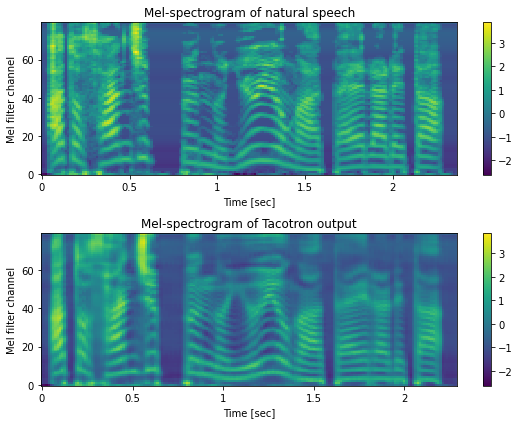

In [56]:
fig, ax = plt.subplots(2, 1, figsize=(8,6))
ax[0].set_title("Mel-spectrogram of natural speech")
ax[1].set_title("Mel-spectrogram of Tacotron output")

mindb = min(feats.min(), out_feats_fine.min())
maxdb = max(feats.max(), out_feats_fine.max())

hop_length = int(sr * 0.0125)
mesh = librosa.display.specshow(
    feats.T, sr=sr, x_axis="time", y_axis="frames", hop_length=hop_length, cmap=cmap, ax=ax[0])
mesh.set_clim(mindb, maxdb)
fig.colorbar(mesh, ax=ax[0])
mesh = librosa.display.specshow(
    out_feats_fine.data.numpy().T, sr=sr, x_axis="time", y_axis="frames", hop_length=hop_length, cmap=cmap, ax=ax[1])
mesh.set_clim(mindb, maxdb)
fig.colorbar(mesh, ax=ax[1])

for a in ax:
    a.set_xlabel("Time [sec]")
    a.set_ylabel("Mel filter channel")
fig.tight_layout()

# 図10-8
savefig("./fig/e2etts_impl_logmel_comp")

#### アテンション重みの可視化

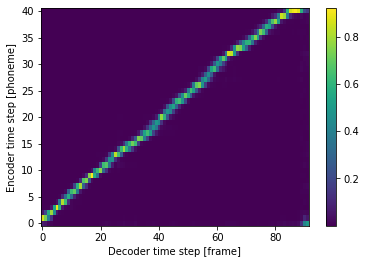

In [57]:
fig, ax = plt.subplots(figsize=(6,4))
im = ax.imshow(alignment.cpu().data.numpy().T, aspect="auto", origin="lower", interpolation="nearest")
fig.colorbar(im, ax=ax)
ax.set_xlabel("Decoder time step [frame]")
ax.set_ylabel("Encoder time step [phoneme]");

#### Stop token の可視化

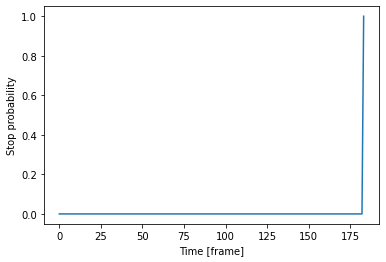

In [58]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(torch.sigmoid(stop_flags).cpu().numpy())
ax.set_xlabel("Time [frame]")
ax.set_ylabel("Stop probability");

### 音声波形の生成

In [59]:
from ttslearn.dsp import inv_mulaw_quantize

@torch.no_grad()
def gen_waveform(wavenet_model, out_feats):
    # (B, T, C) -> (B, C, T)
    c = out_feats.view(1, -1, out_feats.size(-1)).transpose(1, 2)

    # 音声のサンプル数を計算
    upsample_scale = np.prod(wavenet_model.upsample_scales)
    T = (
        c.shape[-1] - wavenet_model.aux_context_window * 2
    ) * upsample_scale

    # WaveNet による音声波形の生成
    # NOTE: 計算に時間がかかるため、tqdm によるプログレスバーを受け付けるようにしています
    gen_wav = wavenet_model.inference(c, T, tqdm)

    # One-hot ベクトルから1次元の信号に変換
    gen_wav = gen_wav.max(1)[1].float().cpu().numpy().reshape(-1)

    # Mu-law 量子化の逆変換
    gen_wav = inv_mulaw_quantize(
        gen_wav, wavenet_model.out_channels - 1
    )
    
    return gen_wav

### すべてのモデルを組み合わせて音声波形の生成

In [60]:
from ttslearn.util import find_lab, find_feats
from ttslearn.dsp import logmelspectrogram_to_audio

# WaveNetボコーダの代わりにGriffin-Limのアルゴリズムを利用する場合、以下をTrueにしてください。
griffin_lim = False

labels = hts.load(find_lab("downloads/jsut-label/", test_utt))
in_feats = text_to_sequence(pp_symbols(labels.contexts))
in_feats = torch.tensor(in_feats, dtype=torch.long).to(device)

with torch.no_grad():
    _, out_feats, _, _ = acoustic_model.inference(in_feats)
    
if griffin_lim:
    # Griffin-Lim のアルゴリズムに基づく音声波形生成
    out_feats = out_feats.cpu().data.numpy()
    # 正規化の逆変換
    logmel = acoustic_out_scaler.inverse_transform(out_feats)
    gen_wav = logmelspectrogram_to_audio(logmel, sr)
else:
    # WaveNet ボコーダによる音声波形の生成
    gen_wav = gen_waveform(wavenet_model, out_feats)

  0%|          | 0/36000 [00:00<?, ?it/s]

In [62]:
# 比較用に元音声の読み込み
from scipy.io import wavfile

_sr, ref_wav = wavfile.read(f"./downloads/jsut_ver1.1/basic5000/wav/{test_utt}.wav")
ref_wav = (ref_wav / 32768.0).astype(np.float64)
ref_wav = librosa.resample(ref_wav, orig_sr=_sr, target_sr=sr)

自然音声


Tacotron 2による合成音声


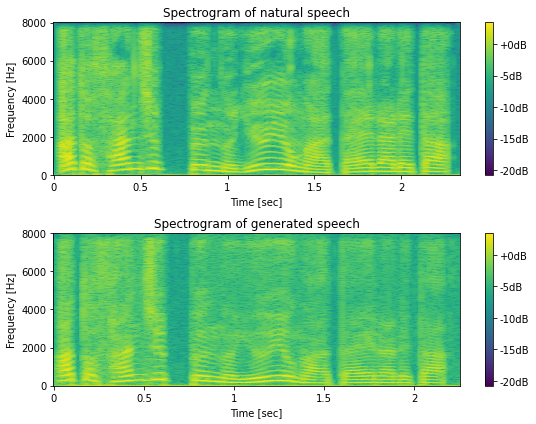

In [63]:
fig, ax = plt.subplots(2, 1, figsize=(8,6))

hop_length = int(sr * 0.005)
fft_size = pyworld.get_cheaptrick_fft_size(sr)

# Tacotronの出力と粗く揃えるために、自然音声の冒頭と末尾の無音区間を削除
ref_wav_trim = librosa.effects.trim(ref_wav, top_db=20)[0]

spec_ref = librosa.stft(ref_wav_trim, n_fft=fft_size, hop_length=hop_length, window="hann")
logspec_ref = np.log(np.abs(spec_ref))
spec_gen = librosa.stft(gen_wav, n_fft=fft_size, hop_length=hop_length, window="hann")
logspec_gen = np.log(np.abs(spec_gen))

mindb = min(logspec_ref.min(), logspec_gen.min())
maxdb = max(logspec_ref.max(), logspec_gen.max())

mesh = librosa.display.specshow(logspec_ref, hop_length=hop_length, sr=sr, cmap=cmap, x_axis="time", y_axis="hz", ax=ax[0])
mesh.set_clim(mindb, maxdb)
fig.colorbar(mesh, ax=ax[0], format="%+2.fdB")

mesh = librosa.display.specshow(logspec_gen, hop_length=hop_length, sr=sr, cmap=cmap, x_axis="time", y_axis="hz", ax=ax[1])
mesh.set_clim(mindb, maxdb)
fig.colorbar(mesh, ax=ax[1], format="%+2.fdB")

ax[0].set_title("Spectrogram of natural speech")
ax[1].set_title("Spectrogram of generated speech")

for a in ax:
    a.set_xlabel("Time [sec]")
    a.set_ylabel("Frequency [Hz]")

plt.tight_layout()

print("自然音声")
IPython.display.display(Audio(ref_wav_trim, rate=sr))
print("Tacotron 2による合成音声")
IPython.display.display(Audio(gen_wav, rate=sr))

# 図10-9
savefig("./fig/e2etts_impl_tts_spec_comp")

### 合成音声のより詳細な比較 (bonus)

In [64]:
# 比較用に、自然音声から抽出されたメルスペクトログラムから音声波形の生成を行います
feats = np.load(find_feats("dump/jsut_sr16000/norm/", test_utt, typ="out_tacotron"))
feats = torch.from_numpy(feats)
gen_wav_wn_gt = gen_waveform(wavenet_model, feats)

  0%|          | 0/37200 [00:00<?, ?it/s]

In [65]:
ref_wav_inv = np.load(find_feats("./dump/jsut_sr16000/org/", test_utt, typ="out_wavenet"))
ref_wav_inv = inv_mulaw_quantize(ref_wav_inv, 255)

In [66]:
print("自然音声")
IPython.display.display(Audio(ref_wav, rate=sr))
print("自然音声 (8-bit mu-law)")
IPython.display.display(Audio(ref_wav_inv, rate=sr))
print("WaveNetボコーダの出力")
IPython.display.display(Audio(gen_wav_wn_gt, rate=sr))
print("Tacotron + WaveNetボコーダの出力")
IPython.display.display(Audio(gen_wav, rate=sr))

自然音声


自然音声 (8-bit mu-law)


WaveNetボコーダの出力


Tacotron + WaveNetボコーダの出力


### 評価データに対して音声波形生成

#### レシピの stage 5 の実行

In [67]:
if run_sh:
    ! ./run.sh --stage 5 --stop-stage 5 --acoustic-model $acoustic_config_name \
        --tqdm $run_sh_tqdm --wavenet-model $wavenet_config_name \
        --reverse true --num-eval-utts $num_eval_utts

#### レシピの stage 6 の実行

In [74]:
f"""
./run.sh --stage 6 --stop-stage 6 --acoustic-model {acoustic_config_name} \
        --wavenet-model {wavenet_config_name} \
        --reverse true --num-eval-utts {num_eval_utts}
"""

'\n/run.sh --stage 6 --stop-stage 6 --acoustic-model tacotron2_rf2         --wavenet-model wavenet_sr16k_mulaw256_30layers         --reverse true --num-eval-utts 5\n\n'

In [73]:
if True:
    ! ./run.sh --stage 6 --stop-stage 6 --acoustic-model $acoustic_config_name \
        --tqdm $run_sh_tqdm --wavenet-model $wavenet_config_name \
        --reverse true --num-eval-utts $num_eval_utts

stage 6: Synthesis waveforms by WaveNet vocoder
+ python synthesis.py utt_list=./data/eval.list tqdm=none in_dir=downloads/jsut-label/labels/basic5000 out_dir=exp/jsut_sr16000/synthesis_tacotron2_rf2_wavenet_sr16k_mulaw256_30layers/eval sample_rate=16000 acoustic.checkpoint=exp/jsut_sr16000/tacotron2_rf2/latest.pth acoustic.out_scaler_path=dump/jsut_sr16000/norm/out_tacotron_scaler.joblib acoustic.model_yaml=exp/jsut_sr16000/tacotron2_rf2/model.yaml wavenet.checkpoint=exp/jsut_sr16000/wavenet_sr16k_mulaw256_30layers/latest_ema.pth wavenet.model_yaml=exp/jsut_sr16000/wavenet_sr16k_mulaw256_30layers/model.yaml use_wavenet=true reverse=true num_eval_utts=5
synthesis.py:17: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="conf/synthesis", config_name="config")
/home/vscode/.local/lib/python3.7/site-packages/hydra/_internal/hydra.py:127: UserWarning: Future Hydra 

## 自然音声と合成音声の比較 (bonus)

In [75]:
from pathlib import Path
from ttslearn.util import load_utt_list

with open("./downloads/jsut_ver1.1/basic5000/transcript_utf8.txt") as f:
    transcripts = {}
    for l in f:
        utt_id, script = l.split(":")
        transcripts[utt_id] = script

eval_list = load_utt_list("data/eval.list")[::-1][:5]

for utt_id in eval_list:
    # ref file
    ref_file = f"./downloads/jsut_ver1.1/basic5000/wav/{utt_id}.wav"
    _sr, ref_wav = wavfile.read(ref_file)
    ref_wav = (ref_wav / 32768.0).astype(np.float64)
    ref_wav = librosa.resample(ref_wav, orig_sr=_sr, target_sr=sr)

    print(f"{utt_id}: {transcripts[utt_id]}")
    print("自然音声")
    IPython.display.display(Audio(ref_wav, rate=sr))

    gen_file = f"exp/jsut_sr16000/synthesis_{acoustic_config_name}_griffin_lim/eval/{utt_id}.wav"
    if exists(gen_file):
        _sr, gen_wav = wavfile.read(gen_file)
        print("Tacotron + Griffin-Lim")
        IPython.display.display(Audio(gen_wav, rate=sr))
    else:
        print("Tacotron + Griffin-Lim: not found")
    print(gen_file_wn)
    gen_file_wn = f"exp/jsut_sr16000/synthesis_{acoustic_config_name}_{wavenet_config_name}/eval/{utt_id}.wav"
    if exists(gen_file_wn):
        _sr, gen_wav_wn = wavfile.read(gen_file_wn)
        print("Tacotron + WaveNetボコーダ")
        IPython.display.display(Audio(gen_wav_wn, rate=sr))
    else:
        print("Tacotron + WaveNetボコーダ: not found")

BASIC5000_5000: あと３０分の猶予が与えられた。

自然音声


Tacotron + Griffin-Lim


exp/jsut_sr16000/synthesis_tacotron2_rf2_wavenet_sr16k_mulaw256_30layers/eval/BASIC5000_4996.wav
Tacotron + WaveNetボコーダ


BASIC5000_4999: ドナーから腎臓の提供を受ける。

自然音声


Tacotron + Griffin-Lim


exp/jsut_sr16000/synthesis_tacotron2_rf2_wavenet_sr16k_mulaw256_30layers/eval/BASIC5000_5000.wav
Tacotron + WaveNetボコーダ


BASIC5000_4998: 村人たちは、その話を聞いて、震え上がった。

自然音声


Tacotron + Griffin-Lim


exp/jsut_sr16000/synthesis_tacotron2_rf2_wavenet_sr16k_mulaw256_30layers/eval/BASIC5000_4999.wav
Tacotron + WaveNetボコーダ


BASIC5000_4997: その王国は、最後の王に嗣子がおらず、滅亡した。

自然音声


Tacotron + Griffin-Lim


exp/jsut_sr16000/synthesis_tacotron2_rf2_wavenet_sr16k_mulaw256_30layers/eval/BASIC5000_4998.wav
Tacotron + WaveNetボコーダ: not found
BASIC5000_4996: 扇型の、弧の長さを、計算で求める。

自然音声


Tacotron + Griffin-Lim


exp/jsut_sr16000/synthesis_tacotron2_rf2_wavenet_sr16k_mulaw256_30layers/eval/BASIC5000_4997.wav
Tacotron + WaveNetボコーダ: not found


## 学習済みモデルのパッケージング (bonus)

学習済みモデルを利用したTTSに必要なファイルをすべて単一のディレクトリにまとめます。
`ttslearn.tacotron.Tacotron2TTS` クラスには、まとめたディレクトリを指定し、TTSを行う機能が実装されています。

### レシピの stage 99 の実行

In [ ]:
if run_sh:
    ! ./run.sh --stage 99 --stop-stage 99 --acoustic-model $acoustic_config_name \
        --wavenet-model $wavenet_config_name

In [ ]:
!ls tts_models/jsut_sr16000_{acoustic_config_name}_{wavenet_config_name}

### パッケージングしたモデルを利用したTTS

In [ ]:
from ttslearn.tacotron import Tacotron2TTS

# パッケージングしたモデルのパスを指定します
engine = Tacotron2TTS(
    model_dir=f"./tts_models/jsut_sr16000_{acoustic_config_name}_{wavenet_config_name}"
)
wav, sr = engine.tts("ここまでお読みいただき、ありがとうございました。", tqdm=tqdm)

fig, ax = plt.subplots(figsize=(8,2))
librosa.display.waveshow(wav.astype(np.float32), sr, ax=ax)
ax.set_xlabel("Time [sec]")
ax.set_ylabel("Amplitude")
plt.tight_layout()

Audio(wav, rate=sr)

In [ ]:
if is_colab():
    from datetime import timedelta
    elapsed = (time.time() - start_time)
    print("所要時間:", str(timedelta(seconds=elapsed)))